In [50]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.tree import plot_tree

In [51]:
from sklearn.feature_selection import RFE

In [68]:
import numpy as np

In [52]:
dta = pd.read_csv('Crop_recommendation.csv', sep=';')

### **Random forest sur l'ensemble des cultures :**

In [53]:
# Séparer les variables explicatives et la variable cible
X = dta.drop(columns='label')  # Toutes les colonnes sauf 'label'
y = dta['label']

# Diviser en jeu d'entraînement et de test (75%/25%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# Modèle Random Forest avec validation croisée à 10 folds
rf_model = RandomForestClassifier(random_state=42)
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Afficher la performance moyenne pendant la validation croisée
scores = cross_val_score(rf_model, X_train, y_train, cv=cv, scoring='accuracy')
print(f"Accuracy moyenne: {scores.mean():.4f}")

# Entraîner le modèle sur l'ensemble d'entraînement
rf_model.fit(X_train, y_train)

# Faire des prédictions sur l'ensemble de test
y_pred = rf_model.predict(X_test)

# Évaluer la performance avec l'accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy sur l'ensemble de test: {accuracy:.4f}")

Accuracy moyenne: 0.9945
Accuracy sur l'ensemble de test: 0.9945


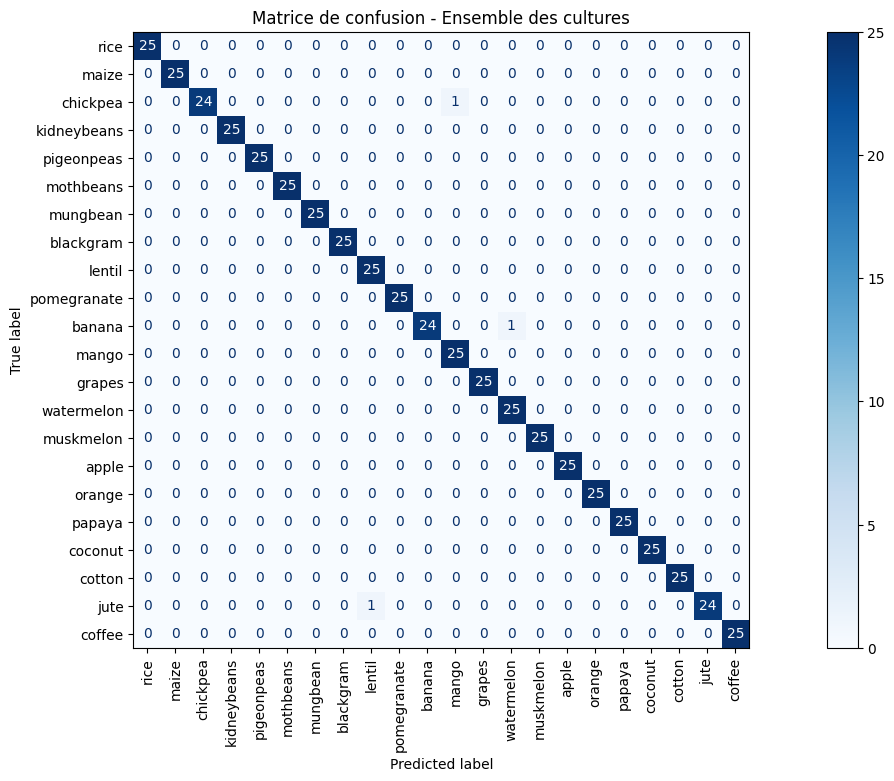

In [54]:
# Afficher la matrice de confusion
unique_labels = y.unique()
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(20, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_labels)
disp.plot(cmap=plt.cm.Blues, ax=plt.gca())
plt.title("Matrice de confusion - Ensemble des cultures")
plt.xticks(rotation=90)
plt.show()

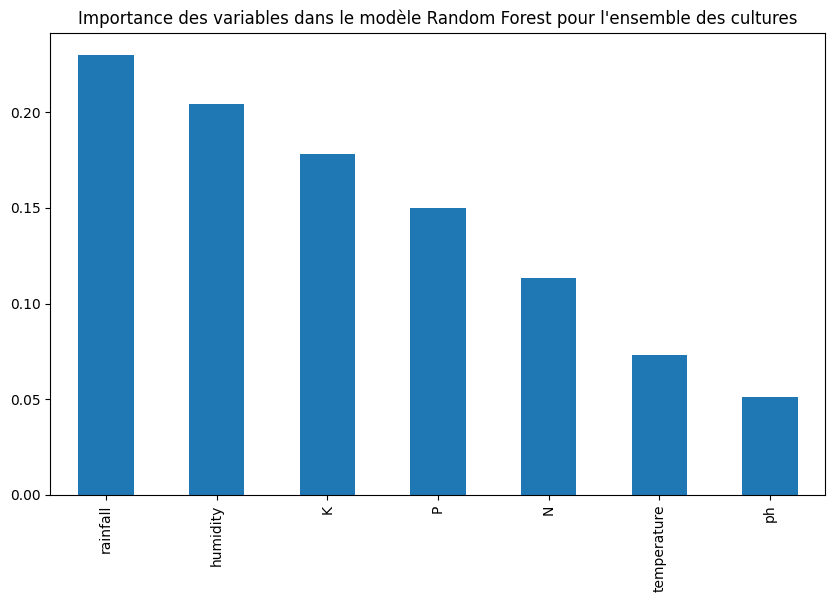

In [55]:
# Afficher l'importance des variables
importances = rf_model.feature_importances_
feature_importance = pd.Series(importances, index=X.columns)
feature_importance.sort_values(ascending=False).plot(kind='bar', figsize=(10, 6))
plt.title('Importance des variables dans le modèle Random Forest pour l\'ensemble des cultures')
plt.show()

Test du meilleur modèle :


Variables sélectionnées avec 1 variables: ['humidity']
Accuracy avec 1 variables sélectionnées: 0.3090909090909091
Variables sélectionnées avec 2 variables: ['humidity', 'rainfall']
Accuracy avec 2 variables sélectionnées: 0.7727272727272727
Variables sélectionnées avec 3 variables: ['K', 'humidity', 'rainfall']
Accuracy avec 3 variables sélectionnées: 0.9636363636363636
Variables sélectionnées avec 4 variables: ['P', 'K', 'humidity', 'rainfall']
Accuracy avec 4 variables sélectionnées: 0.9745454545454545
Variables sélectionnées avec 5 variables: ['N', 'P', 'K', 'humidity', 'rainfall']
Accuracy avec 5 variables sélectionnées: 0.9945454545454545
Variables sélectionnées avec 6 variables: ['N', 'P', 'K', 'temperature', 'humidity', 'rainfall']
Accuracy avec 6 variables sélectionnées: 0.990909090909091
Variables sélectionnées avec 7 variables: ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']
Accuracy avec 7 variables sélectionnées: 0.9945454545454545
Nombre optimal de variables:

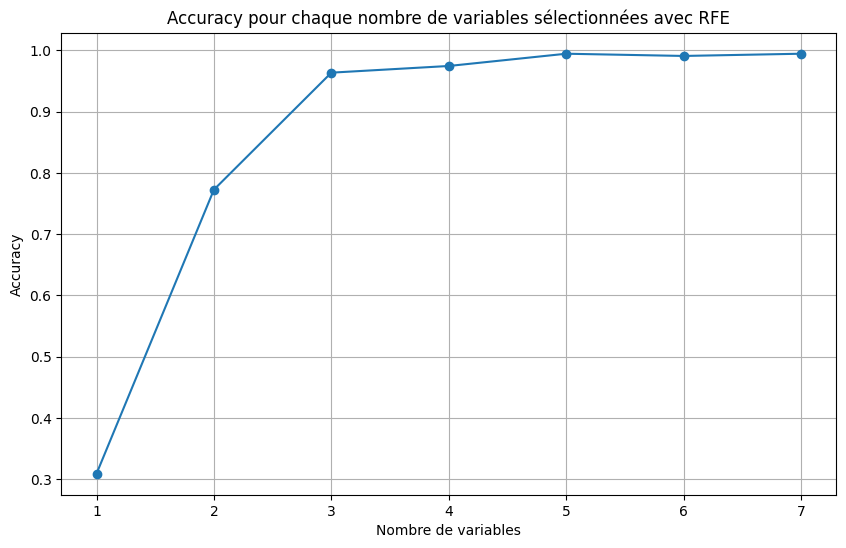

In [56]:
# Initialiser un dictionnaire pour stocker les résultats
results = {}

# Boucler sur le nombre de variables à sélectionner (de 1 jusqu'au nombre total de variables)
for num_features in range(1, X_train.shape[1] + 1):
    # Mettre en place RFE pour tester avec num_features variables
    rfe = RFE(estimator=rf_model, n_features_to_select=num_features, step=1)

    # Appliquer RFE pour ajuster le modèle
    rfe.fit(X_train, y_train)

    #Résumer les résultats : Afficher les variables sélectionnées
    selected_features = X.columns[rfe.support_]
    print(f"Variables sélectionnées avec {num_features} variables: {list(selected_features)}")

    #Évaluer les performances du modèle sur l'ensemble de test
    y_pred = rfe.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy avec {num_features} variables sélectionnées: {accuracy}")

    # Stocker le résultat dans le dictionnaire
    results[num_features] = accuracy

#Trouver le nombre optimal de variables
best_num_features = max(results, key=results.get)
best_accuracy = results[best_num_features]

# Afficher le meilleur résultat
print(f"Nombre optimal de variables: {best_num_features}")
print(f"Meilleure accuracy: {best_accuracy}")

# Optionnel : Afficher les performances pour chaque nombre de variables
plt.figure(figsize=(10, 6))
plt.plot(list(results.keys()), list(results.values()), marker='o')
plt.title('Accuracy pour chaque nombre de variables sélectionnées avec RFE')
plt.xlabel('Nombre de variables')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

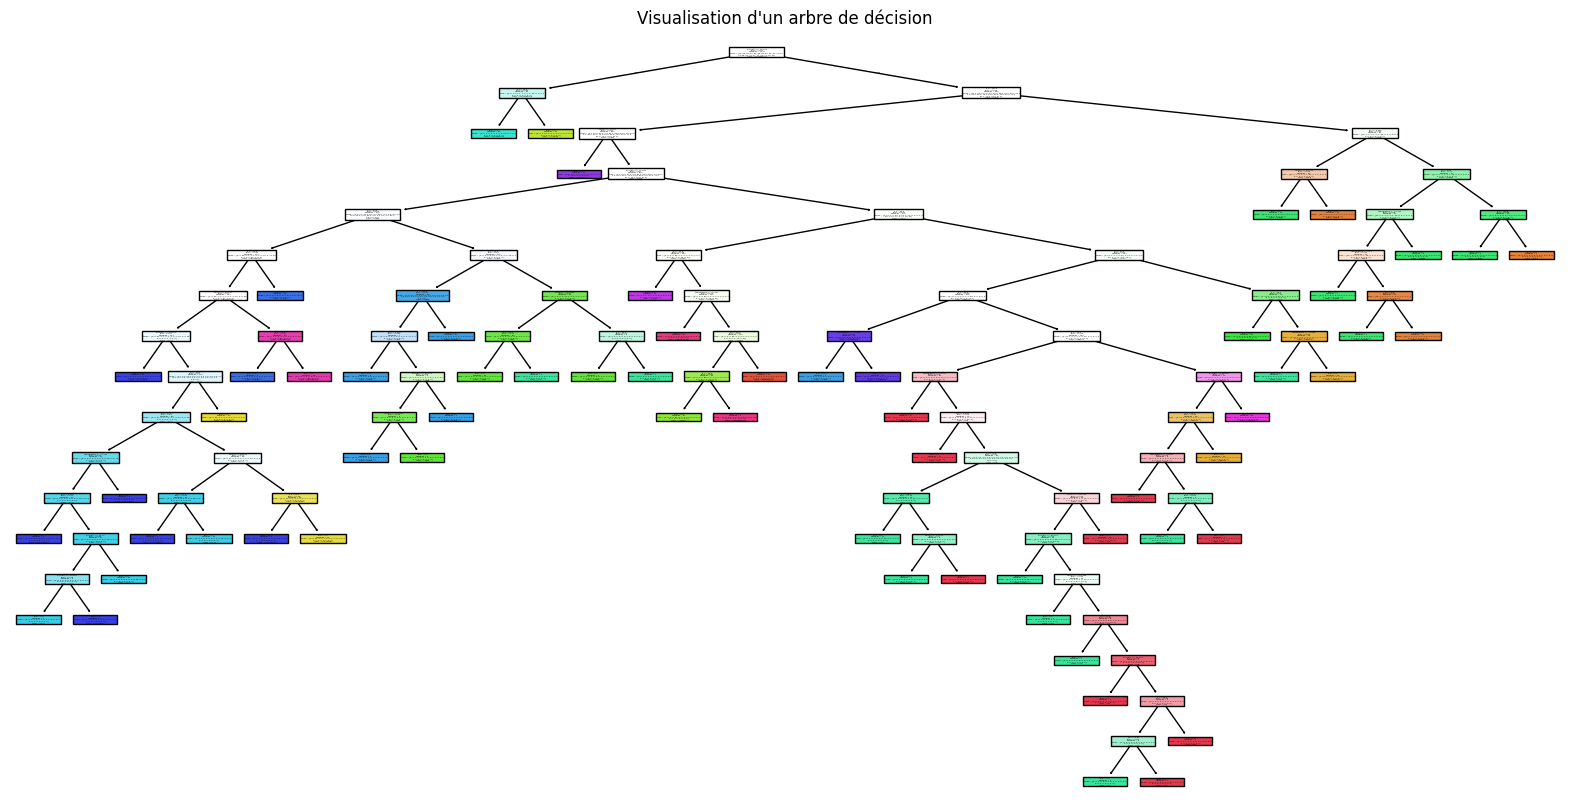

In [57]:
# Visualisation d'un arbre de décision
plt.figure(figsize=(20, 10))
plot_tree(rf_model.estimators_[0], feature_names=X.columns, class_names=rf_model.classes_, filled=True)
plt.title('Visualisation d\'un arbre de décision')
plt.show()

### **Random forest sur les sous-ensembles de cultures similaires :**

In [85]:
# Filtrer les cultures similaires (Coffee, Cotton, Maize, Rice, Jute)
cultures_similaires = ['coffee', 'cotton', 'maize', 'rice', 'jute']
filtered_data = y_test.isin(cultures_similaires)

# Réassigner X et y pour les sous-ensembles de cultures similaires
X_test_filtered = X_test[filtered_data]
y_test_filtered = y_test[filtered_data]

# Prédictions sur l'ensemble de test filtré
pred_filtered = rf_model.predict(X_test_filtered)

# Évaluer la performance avec l'accuracy sur cet ensemble filtré
accuracy_filtered = accuracy_score(y_test_filtered, pred_filtered)
print(f"Accuracy pour les cultures similaires : {accuracy_filtered:.4f}")

Accuracy pour les cultures similaires : 0.9920


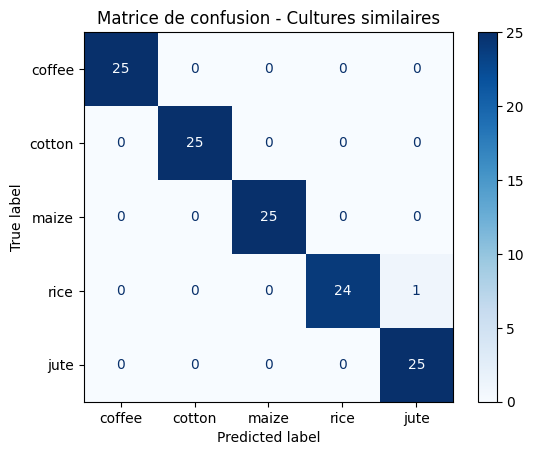

In [86]:
# Matrice de confusion pour le sous-ensemble
conf_matrix_filtered = confusion_matrix(y_test_filtered, pred_filtered, labels=cultures_similaires)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_filtered, display_labels=cultures_similaires)
disp.plot(cmap=plt.cm.Blues)
plt.title("Matrice de confusion - Cultures similaires")
plt.show()

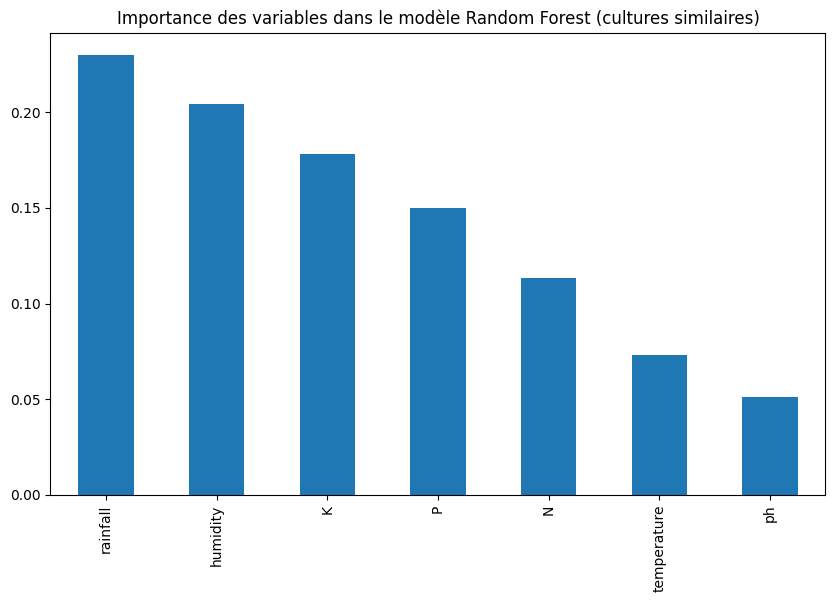

In [87]:
# Afficher l'importance des variables
importances_similar = rf_model.feature_importances_
feature_importance_similar = pd.Series(importances_similar, index=X_test_filtered.columns)
feature_importance_similar.sort_values(ascending=False).plot(kind='bar', figsize=(10, 6))
plt.title('Importance des variables dans le modèle Random Forest (cultures similaires)')
plt.show()

test

Variables sélectionnées avec 1 variables: ['humidity']
Accuracy avec 1 variables sélectionnées: 0.2400
Variables sélectionnées avec 2 variables: ['humidity', 'rainfall']
Accuracy avec 2 variables sélectionnées: 0.8480
Variables sélectionnées avec 3 variables: ['K', 'humidity', 'rainfall']
Accuracy avec 3 variables sélectionnées: 0.9200
Variables sélectionnées avec 4 variables: ['P', 'K', 'humidity', 'rainfall']
Accuracy avec 4 variables sélectionnées: 0.9200
Variables sélectionnées avec 5 variables: ['N', 'P', 'K', 'humidity', 'rainfall']
Accuracy avec 5 variables sélectionnées: 0.9920
Variables sélectionnées avec 6 variables: ['N', 'P', 'K', 'temperature', 'humidity', 'rainfall']
Accuracy avec 6 variables sélectionnées: 0.9840
Variables sélectionnées avec 7 variables: ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']
Accuracy avec 7 variables sélectionnées: 0.9920
Nombre optimal de variables: 5
Meilleure accuracy: 0.9920


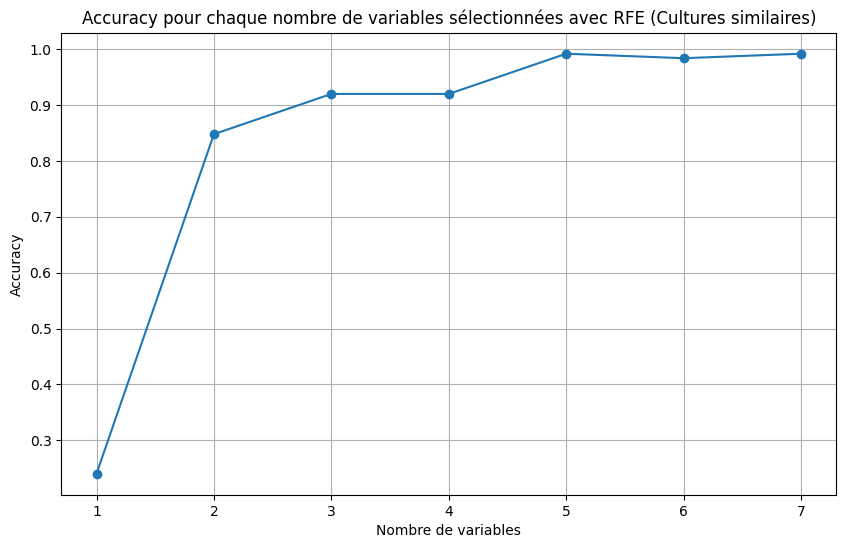

In [83]:
# Initialiser un dictionnaire pour stocker les résultats
results = {}

# Boucler sur le nombre de variables à sélectionner (de 1 jusqu'au nombre total de variables)
for num_features in range(1, X_train.shape[1] + 1):
    # Mettre en place RFE pour tester avec num_features variables
    rfe = RFE(estimator=rf_model, n_features_to_select=num_features, step=1)

    # Appliquer RFE pour ajuster le modèle
    rfe.fit(X_train, y_train)

    # Résumer les résultats : Afficher les variables sélectionnées
    selected_features = X.columns[rfe.support_]
    print(f"Variables sélectionnées avec {num_features} variables: {list(selected_features)}")

    # Évaluer les performances du modèle sur l'ensemble de test
    X_test_selected = X_test[filtered_data]
    y_pred = rfe.predict(X_test_selected)

    # Calculer l'accuracy
    accuracy = accuracy_score(y_test_filtered, y_pred)
    print(f"Accuracy avec {num_features} variables sélectionnées: {accuracy:.4f}")

    # Stocker le résultat dans le dictionnaire
    results[num_features] = accuracy

# Trouver le nombre optimal de variables
best_num_features = max(results, key=results.get)
best_accuracy = results[best_num_features]

# Afficher le meilleur résultat
print(f"Nombre optimal de variables: {best_num_features}")
print(f"Meilleure accuracy: {best_accuracy:.4f}")

# Optionnel : Afficher les performances pour chaque nombre de variables
plt.figure(figsize=(10, 6))
plt.plot(list(results.keys()), list(results.values()), marker='o')
plt.title('Accuracy pour chaque nombre de variables sélectionnées avec RFE (Cultures similaires)')
plt.xlabel('Nombre de variables')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()


In [96]:
# Visualisation d'un arbre de décision
plt.figure(figsize=(150, 50))
plot_tree(rf_model.estimators_[0],
          feature_names=X_test_filtered.columns,
          class_names=rf_model.classes_,
          filled=True)
plt.title('Visualisation d\'un arbre de décision (cultures similaires)')
plt.show()

Output hidden; open in https://colab.research.google.com to view.

**Random forest sur les sous-ensembles de cultures différentes :**

In [ ]:
# Filtrer les cultures variées (Banana, Lentil, Apple, Mango, Chickpea)
cultures_variees = ['banana', 'lentil', 'apple', 'mango', 'chickpea']
filtered_data_variees = dta[dta['label'].isin(cultures_variees)]

# Réassigner X et y pour les sous-ensembles de cultures variées
X_filtered_variees = filtered_data_variees.drop(columns='label')
y_filtered_variees = filtered_data_variees['label']

# Diviser en jeu d'entraînement et de test (75%/25%)
X_train_variees, X_test_variees, y_train_variees, y_test_variees = train_test_split(X_filtered_variees, y_filtered_variees, test_size=0.25, random_state=42)

# Entraîner le modèle Random Forest
rf_model_variees = RandomForestClassifier(random_state=42)
rf_model_variees.fit(X_train_variees, y_train_variees)

# Prédictions sur l'ensemble de test filtré
y_pred_filtered_variees = rf_model_variees.predict(X_test_variees)

In [ ]:
# Matrice de confusion et précision pour le sous-ensemble
conf_matrix_filtered_variees = confusion_matrix(y_test_variees, y_pred_filtered_variees)
accuracy_filtered_variees = accuracy_score(y_test_variees, y_pred_filtered_variees)

print(f"Matrice de confusion sur les sous-ensembles de cultures différentes :\n{conf_matrix_filtered_variees}")
print(f"Accuracy des sous-ensembles de cultures différentes : {accuracy_filtered_variees}")


Matrice de confusion sur les sous-ensembles de cultures différentes :
[[27  0  0  0  0]
 [ 0 17  0  0  0]
 [ 0  0 32  0  0]
 [ 0  0  0 19  0]
 [ 0  0  0  0 30]]
Accuracy des sous-ensembles de cultures différentes : 1.0


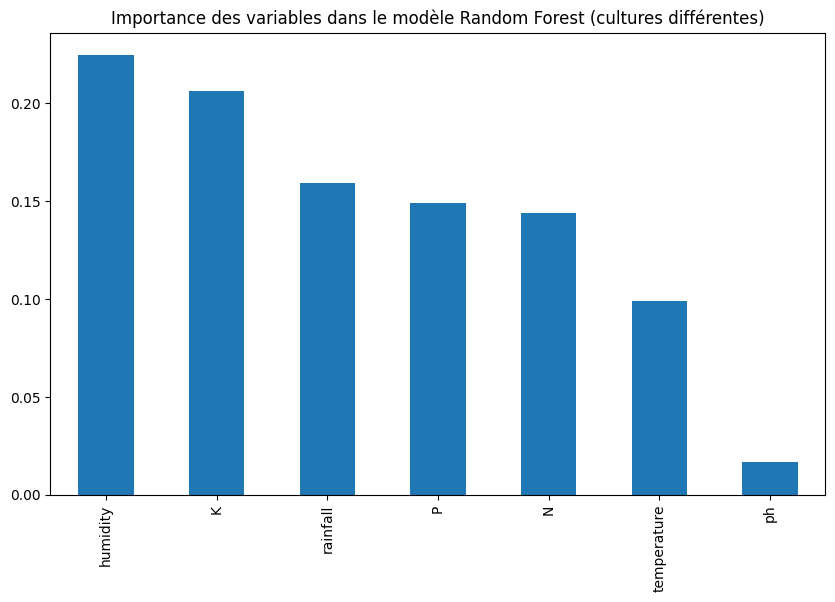

In [ ]:
# Afficher l'importance des variables
importances_variees = rf_model_variees.feature_importances_
feature_importance_variees = pd.Series(importances_variees, index=X_filtered_variees.columns)
feature_importance_variees.sort_values(ascending=False).plot(kind='bar', figsize=(10, 6))
plt.title('Importance des variables dans le modèle Random Forest (cultures différentes)')
plt.show()

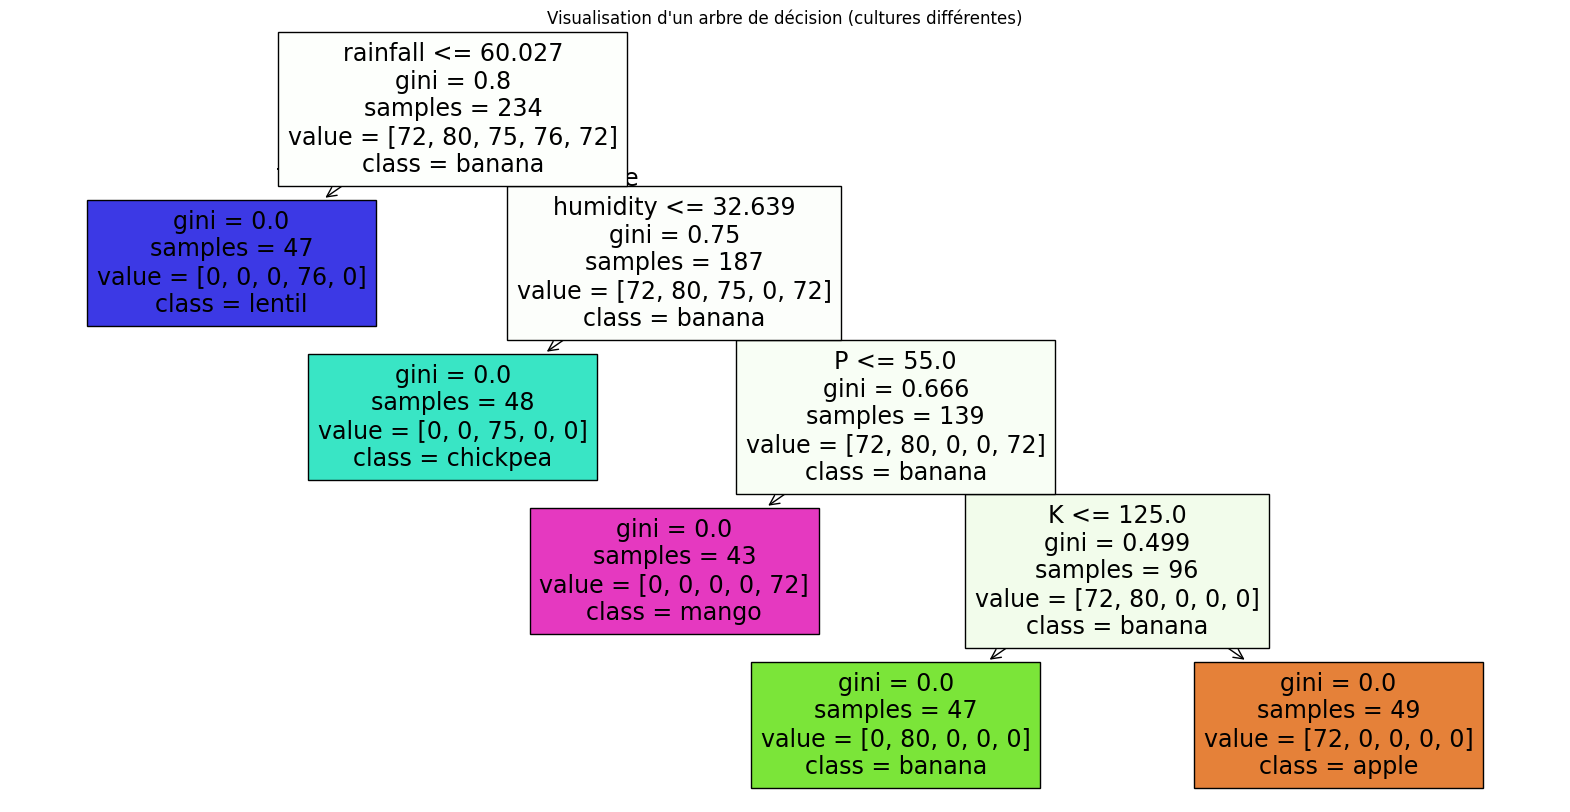

In [ ]:
# Visualisation d'un arbre de décision
plt.figure(figsize=(20, 10))
plot_tree(rf_model_variees.estimators_[0],
          feature_names=X_filtered_variees.columns,
          class_names=rf_model_variees.classes_,
          filled=True)
plt.title('Visualisation d\'un arbre de décision (cultures différentes)')
plt.show()